In [37]:
import os
import numpy as np
import pandas as pd
import csv
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import load_model, Sequential, Model
from keras.layers import Dense, Dropout, Softmax, BatchNormalization, Embedding, LSTM, SimpleRNN
from keras.initializers import GlorotNormal, GlorotUniform
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from keras.regularizers import L1L2

In [4]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


## Song Classifier

### RNN (LSTM)

Dataset: https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres

#### Import Data


In [53]:
base_dir = './data'

In [87]:
with open(f'{base_dir}/train.npy', 'rb') as f:
    training_pd = np.load(f)
    training_lbls = np.load(f)
    size = np.load(f)
    
with open(f'{base_dir}/test.npy', 'rb') as f:
    testing_pd = np.load(f)
    testing_lbls = np.load(f)

In [55]:
training_pd[:1]

array([[  61, 6210,    1,    1, 6202,  292, 9177,  900, 1029,    1, 7490,
        2598, 3394, 5549,    1,    1,    1, 2925,    1,    1,    1, 7490,
        2598,   61, 6210,    1,    1, 6202, 4408,  292, 3682,    1,    1,
        7490,   89, 4588, 5286, 1135, 1144,    1, 5286,    1, 5303, 5286,
           1, 5484, 2626,    1, 2598,  689,  155,    1,  386,  689,  155,
           1, 1443,   99,    1, 5303, 7056,    1,   56, 9428,    1,    1,
        3824, 7056, 4644,  689, 6609,   61, 6210,    1,    1, 6202, 4408,
         292,    1,    1, 3067, 5303, 4611, 4408, 5286,  467, 2963, 5286,
        5391,  643, 2421, 2204, 5484,    1,    1, 4065, 8922, 2598, 5303,
        6210,    1,    1, 6202, 4408, 5286,    1, 5925, 5484, 1518, 7007,
        8918,  292,  333, 1613, 4568, 3392, 5549,  292, 1829, 1231,    1,
        5303, 5635,    1,    1, 6786, 2598,  689]])

In [46]:
training_lbls[:1]

array([[0., 0., 1.]])

array(['x0_Hip Hop', 'x0_Pop', 'x0_Rock'], dtype=object)

#### Trainning

In [60]:
VOCAB_SIZE = size
EMBEDDING_DIM = 32
MAX_LENGTH = 128
TRUNC_TYPE = 'post'
PADDING_TYPE = 'post'
OOV_TOK = "<OOV>"
EPOCHS = 5

In [10]:
#### Trainning Callbacks
def _get_checkpoint_cb(path, experiment_id, eval_metric):
    return ModelCheckpoint(filepath=f"{path}/experiment_{experiment_id}/checkpoint_{experiment_id}", 
                                                               save_weights_only = True,
                                                               monitor = f'val_{eval_metric}',
                                                               save_best_only = True,
                                                               verbose = 1)

def _get_early_stopping_cb(path, experiment_id, eval_metric):
    return EarlyStopping(monitor = f'val_{eval_metric}', patience = 3, restore_best_weights = True)

def _get_tensorboard_cb(path, experiment_id, eval_metric):
    return TensorBoard(log_dir=f"{path}/logs/tensorboard/experiment_{experiment_id}", 
                                          histogram_freq=10, 
                                          write_graph=True, 
                                          write_images=False, 
                                          write_steps_per_second=False, 
                                          update_freq="epoch", 
                                          profile_batch=2, 
                                          embeddings_freq=10, 
                                          embeddings_metadata=None)

In [11]:
from os.path import exists

class RNNExperiments():
    def __init__(self, results_path, eval_metric, batch_size, epochs=20, val_split=0.2, training_callbacks = None, evaluation_cb=None):
        self.path = results_path
        self.current_model = None
        self.current_history = None
        self.eval_metric = eval_metric
        self.epochs = epochs
        self.batch_size = batch_size
        self.val_split = val_split
        self._callbacks = []
        self.evaluation_cb = evaluation_cb
        self._init_files()
        print(f"Current Experiment Id = {self._current_experiment_id}")
        
    def _init_files(self):
        file_exists = exists(f'{self.path}/logs/models.npy')
        if not file_exists:
            self._current_experiment_id = 0
            self.update_experiment_id()
        else:
            self._current_experiment_id = np.load(f'{self.path}/logs/models.npy')[0]
        
        ### experiments file
        path = f'{self.path}/logs/experiments.csv'
        file_exists = exists(path)
        if not file_exists:
            header = ["ExperimentID", "Datetime", f"train_{self.eval_metric}" ,f"val_{self.eval_metric}"]
            with open(path, '+w') as f:
                # create the csv writer
                writer = csv.writer(f)
                # write a row to the csv file
                writer.writerow(header)
        ### results file
        path = f'{self.path}/logs/test_results.csv'
        file_exists = exists(path)
        if not file_exists:
            header = ["ExperimentID", "Datetime", "test_loss" ,f"test_{self.eval_metric}"] if not self.evaluation_cb else ["ExperimentID", "Datetime", "test_loss" ,f"test_{self.eval_metric}", "custom_metric"]
            with open(path, '+w') as f:
                # create the csv writer
                writer = csv.writer(f)
                # write a row to the csv file
                writer.writerow(header)
                                                    
    
    def add_callback(self, build_cb):
        self._callbacks.append(build_cb)
        return self

    def run_experiment(self, model, train_x, train_y=None, batch_size=None, class_weight=None, verbose=1):
        self.current_model = model
        self.current_history = model.fit(
                                        x = train_x,
                                        y = train_y,
                                        epochs = self.epochs,
                                        verbose=verbose,
                                        shuffle=True,
                                        batch_size = batch_size or self.batch_size,
                                        validation_split = self.val_split,
                                        callbacks = list(map(lambda build_cb: build_cb(self.path, self._current_experiment_id, self.eval_metric), self._callbacks)),
                                        class_weight=class_weight)
        self._current_experiment_id += 1
        self.save_experiment()
        return self.current_model, self._current_experiment_id
    
    def run_experiment_generator(self, model, train_gen, val_gen, verbose=1):
        self.current_model = model
        self.current_history = model.fit(
                                        train_gen,
                                        epochs = self.epochs,
                                        verbose=verbose,
                                        shuffle=True,
                                        validation_data = val_gen,
                                        callbacks = list(map(lambda build_cb: build_cb(self.path, self._current_experiment_id, self.eval_metric), self._callbacks)))
        self._current_experiment_id += 1
        self.save_experiment()
        return self.current_model, self._current_experiment_id
    
    def update_experiment_id(self):
        np.save(f'{self.path}/logs/models.npy', [self._current_experiment_id])
        
    def save_experiment(self):
        experiment_id = self.get_current_experiment_id()
        self.update_experiment_id()
        history = self.current_history.history
        train_result = history[self.eval_metric][len(history[self.eval_metric]) - 1]
        val_result = history[f"val_{self.eval_metric}"][len(history[f"val_{self.eval_metric}"]) - 1]
        self.current_model.save(f"{self.path}/experiment_{experiment_id}")
        res = pd.DataFrame({'ExperimentId': experiment_id, 'Datetime': datetime.now().strftime("%Y%m%d-%H:%M:%S"), 
                            f"train_{self.eval_metric}": train_result, 
                            f"val_{self.eval_metric}": val_result}, index=[0])
        res.to_csv(f'{self.path}/logs/experiments.csv', mode='+a', index = False, header = False)
            
    def plot_model_loss(self, metric=None):
        if not self.current_history:
            return None
        history = self.current_history
        plt.figure(self.get_current_experiment_id())
        plt.plot(history.history[metric or 'loss'])
        plt.plot(history.history[f'val_{metric or "loss"}'])
        plt.legend(['Training', 'Validation'])
        plt.title(f'Train/Val {metric or "Loss"} {self.get_current_experiment_id()}')
        plt.xlabel('Epoch') 
        plt.show()
            
    
    def get_model(self, model_id=None):
        return load_model(f"{self.path}/experiment_{model_id}") if model_id else self.current_model
    
    def summary_experiments(self):
        return pd.read_csv(f'{self.path}/logs/experiments.csv').sort_values(by = f"val_{self.eval_metric}")
    
    def get_current_experiment_id(self):
        return self._current_experiment_id
    
    def save_results(self, test_loss, test_metric, custom_metric=None):
        res = pd.DataFrame({'ExperimentId': self.get_current_experiment_id(), 'Datetime': datetime.now().strftime("%Y%m%d-%H:%M:%S"), 
         f"test_loss": test_loss, f"test_{self.eval_metric}": test_metric, "test_metric": custom_metric}, index=[0])
        res.to_csv(f'{self.path}/logs/test_results.csv', mode='+a', index = False, header = False)
            
    def test(self, x_test, y_test=None):
        if not self.current_model:
            raise Exception("No model trained")
        test_loss, test_metric = self.current_model.evaluate(x_test, y_test)
        self.save_results(test_loss, test_metric, None)
# return metrics.classification_report(y_true, y_hat, digits=3)
        return test_loss, test_metric

    def compare_test_results(self):
        return pd.read_csv(f'{self.path}/logs/test_results.csv')
    
    def predict(self, x_test):
        if not self.current_model:
            raise Exception("No model trained")
        return self.current_model.predict(x_test)
    
    def set_current_model(self, model_id):
        try:
            self.current_model = self.get_model(model_id)
        except:
            raise Exception("Error al cargar modelo. Verificar Id de Modelo.")



#### RNN Model

In [61]:
print(VOCAB_SIZE, EMBEDDING_DIM, MAX_LENGTH, sep='\n')

10000
32
128


In [69]:
experiment_controller = RNNExperiments("./songs", "accuracy", batch_size = 128, epochs=EPOCHS)
experiment_controller.add_callback(_get_checkpoint_cb).add_callback(_get_tensorboard_cb).add_callback(_get_early_stopping_cb)

Current Experiment Id = 26


In [15]:
training_pd.shape

(66162, 128)

In [68]:
training_lbls.shape

(66162, 3)

In [ ]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    LSTM(64), 
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

In [ ]:
model, exp_id = experiment_controller.run_experiment(model, training_pd, training_lbls)

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(testing_pd, testing_lbls))


In [22]:
print(experiment_controller.test(testing_pd, testing_lbls))

887/887 [==============================] - 5s 6ms/step - loss: 0.7245 - accuracy: 0.6762
(0.7244924306869507, 0.6761884689331055)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 32)           3563712   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                6208      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 3,572,099
Trainable params: 3,572,099
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
414/414 [==============================] - 114s 264ms/step - loss: 0.9881 - accuracy: 0.5204 - val_loss: 0.9569 - val_accuracy: 0.5310

Epoch 00001: val_accuracy improved from -inf to 0.53102, saving model to ./songs/experiment_6\ch

INFO:tensorflow:Assets written to: ./songs/experiment_7\assets


ExperimentId: 7


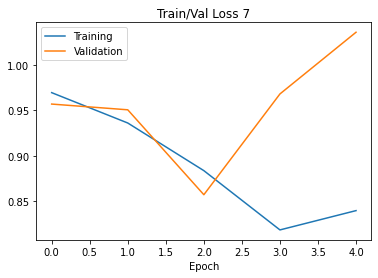

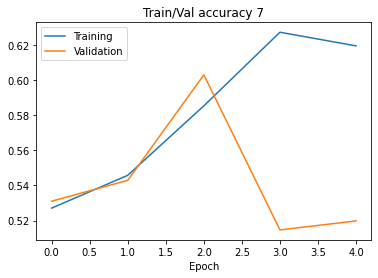

887/887 [==============================] - 20s 22ms/step - loss: 1.0350 - accuracy: 0.5164
(1.0350042581558228, 0.5163986682891846)


In [23]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    SimpleRNN(64), 
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
model, exp_id = experiment_controller.run_experiment(model, training_pd, training_lbls)

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(testing_pd, testing_lbls))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 32)           3563712   
_________________________________________________________________
module_wrapper (ModuleWrappe (None, 64)                16640     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 99        
Total params: 3,582,531
Trainable params: 3,582,531
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
414/414 [==============================] - 19s 40ms/step - loss: 0.8924 - accuracy: 0.5744 - val_loss: 0.7169 - val_accuracy: 0.6769

Epoch 00001: val_accuracy improved from -inf to 0.67694, saving model to ./songs/experiment_7\checkpoint_7
Epoch 2/5
414/414 [==============================] - 16s 39ms/step - loss: 0.6515 - accuracy: 0.7152 - val_loss: 0.7002 - val_accuracy: 0.6832

Epoch 00002: val_accuracy improved from 0.67694 to 0.68322, saving model to ./songs/experiment_7\checkpoint_7
Epoch 3/5
414/414 [==============================] - 16s 39ms/step - loss: 0.5580 - accuracy: 0.7556 - val_loss: 0.7199 - val_accuracy: 0.6785

Epoch 00003: val_accuracy did not improve from 0.68322
Epoch 4/5
414/414 [==============================] - 16s 38ms/step - loss: 0.4860 - accuracy: 0.7889 - val_loss: 0.7743 - val_accuracy: 0.6686

Epoch 00004: val_accuracy did not improve from 0.68322
Epoch 5/5
414/414 [==============================] - 16s 38ms/step - loss: 0.4218 - accuracy: 0.8

INFO:tensorflow:Assets written to: ./songs/experiment_8\assets


INFO:tensorflow:Assets written to: ./songs/experiment_8\assets


ExperimentId: 8


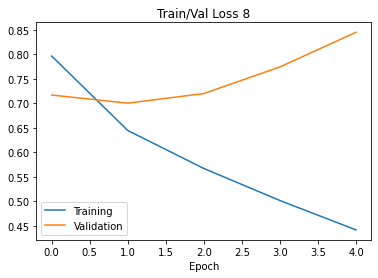

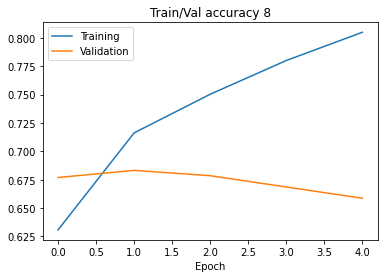

887/887 [==============================] - 7s 8ms/step - loss: 0.6916 - accuracy: 0.6880
(0.6916378736495972, 0.6880378127098083)


In [26]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), 
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
model, exp_id = experiment_controller.run_experiment(model, training_pd, training_lbls)

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(testing_pd, testing_lbls))

Epoch 1/5
414/414 [==============================] - 17s 36ms/step - loss: 0.9038 - accuracy: 0.5724 - val_loss: 0.7345 - val_accuracy: 0.6723

Epoch 00001: val_accuracy improved from -inf to 0.67233, saving model to ./songs/experiment_9\checkpoint_9
Epoch 2/5
414/414 [==============================] - 14s 34ms/step - loss: 0.6827 - accuracy: 0.7007 - val_loss: 0.7323 - val_accuracy: 0.6811

Epoch 00002: val_accuracy improved from 0.67233 to 0.68110, saving model to ./songs/experiment_9\checkpoint_9
Epoch 3/5
414/414 [==============================] - 14s 33ms/step - loss: 0.6097 - accuracy: 0.7404 - val_loss: 0.7348 - val_accuracy: 0.6704

Epoch 00003: val_accuracy did not improve from 0.68110
Epoch 4/5
414/414 [==============================] - 14s 33ms/step - loss: 0.5514 - accuracy: 0.7690 - val_loss: 0.7649 - val_accuracy: 0.6712

Epoch 00004: val_accuracy did not improve from 0.68110
Epoch 5/5
414/414 [==============================] - 14s 34ms/step - loss: 0.5047 - accuracy: 0.7

INFO:tensorflow:Assets written to: ./songs/experiment_10\assets


INFO:tensorflow:Assets written to: ./songs/experiment_10\assets


ExperimentId: 10


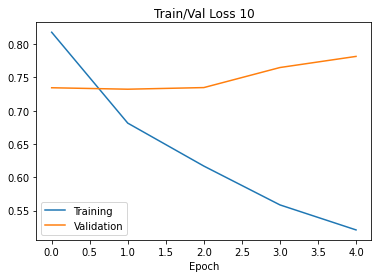

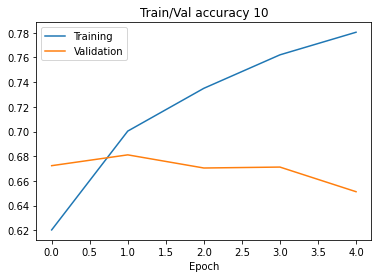

887/887 [==============================] - 5s 5ms/step - loss: 0.7211 - accuracy: 0.6837
(0.7211201190948486, 0.683664858341217)
887/887 [==============================] - 5s 5ms/step - loss: 0.7211 - accuracy: 0.6837
Results:  adam   10   [0.7211201190948486, 0.683664858341217]
Epoch 1/5
414/414 [==============================] - 16s 31ms/step - loss: 0.6062 - accuracy: 0.7399 - val_loss: 0.7363 - val_accuracy: 0.6755

Epoch 00001: val_accuracy improved from -inf to 0.67551, saving model to ./songs/experiment_10\checkpoint_10
Epoch 2/5
414/414 [==============================] - 11s 27ms/step - loss: 0.5651 - accuracy: 0.7614 - val_loss: 0.7642 - val_accuracy: 0.6606

Epoch 00002: val_accuracy did not improve from 0.67551
Epoch 3/5
414/414 [==============================] - 12s 28ms/step - loss: 0.5315 - accuracy: 0.7753 - val_loss: 0.8504 - val_accuracy: 0.6352

Epoch 00003: val_accuracy did not improve from 0.67551
Epoch 4/5
414/414 [==============================] - 12s 28ms/step - 

INFO:tensorflow:Assets written to: ./songs/experiment_11\assets


INFO:tensorflow:Assets written to: ./songs/experiment_11\assets


ExperimentId: 11


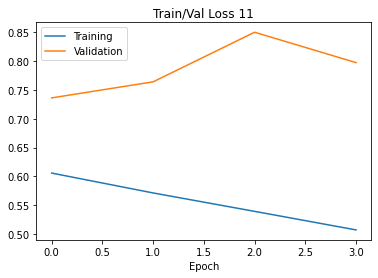

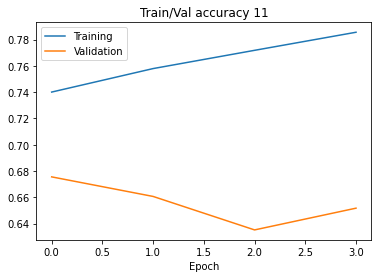

887/887 [==============================] - 5s 5ms/step - loss: 0.7223 - accuracy: 0.6804
(0.7223225831985474, 0.6803851127624512)
887/887 [==============================] - 5s 5ms/step - loss: 0.7223 - accuracy: 0.6804
Results:  nadam   11   [0.7223225831985474, 0.6803851127624512]
Epoch 1/5
414/414 [==============================] - 8s 15ms/step - loss: 0.5466 - accuracy: 0.7732 - val_loss: 0.7568 - val_accuracy: 0.6781

Epoch 00001: val_accuracy improved from -inf to 0.67808, saving model to ./songs/experiment_11\checkpoint_11
Epoch 2/5
414/414 [==============================] - 6s 14ms/step - loss: 0.5260 - accuracy: 0.7777 - val_loss: 0.7703 - val_accuracy: 0.6772

Epoch 00002: val_accuracy did not improve from 0.67808
Epoch 3/5
414/414 [==============================] - 6s 13ms/step - loss: 0.5153 - accuracy: 0.7848 - val_loss: 0.7715 - val_accuracy: 0.6763

Epoch 00003: val_accuracy did not improve from 0.67808
Epoch 4/5
414/414 [==============================] - 6s 13ms/step - l

INFO:tensorflow:Assets written to: ./songs/experiment_12\assets


INFO:tensorflow:Assets written to: ./songs/experiment_12\assets


ExperimentId: 12


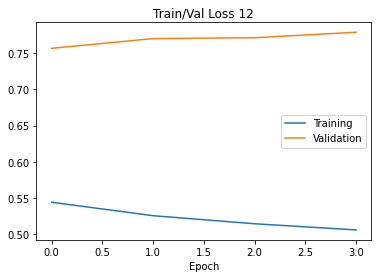

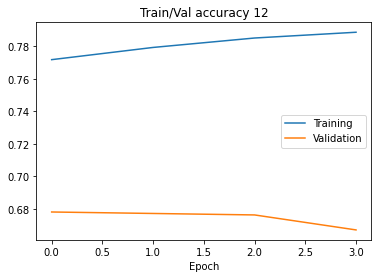

887/887 [==============================] - 5s 5ms/step - loss: 0.7466 - accuracy: 0.6790
(0.7465694546699524, 0.679009735584259)
887/887 [==============================] - 5s 5ms/step - loss: 0.7466 - accuracy: 0.6790
Results:  adamax   12   [0.7465694546699524, 0.679009735584259]
Epoch 1/5
414/414 [==============================] - 8s 14ms/step - loss: 0.5168 - accuracy: 0.7844 - val_loss: 0.7566 - val_accuracy: 0.6720

Epoch 00001: val_accuracy improved from -inf to 0.67203, saving model to ./songs/experiment_12\checkpoint_12
Epoch 2/5
414/414 [==============================] - 5s 13ms/step - loss: 0.5254 - accuracy: 0.7807 - val_loss: 0.7615 - val_accuracy: 0.6777

Epoch 00002: val_accuracy improved from 0.67203 to 0.67770, saving model to ./songs/experiment_12\checkpoint_12
Epoch 3/5
414/414 [==============================] - 5s 13ms/step - loss: 0.5159 - accuracy: 0.7858 - val_loss: 0.7588 - val_accuracy: 0.6772

Epoch 00003: val_accuracy did not improve from 0.67770
Epoch 4/5
414

INFO:tensorflow:Assets written to: ./songs/experiment_13\assets


INFO:tensorflow:Assets written to: ./songs/experiment_13\assets


ExperimentId: 13


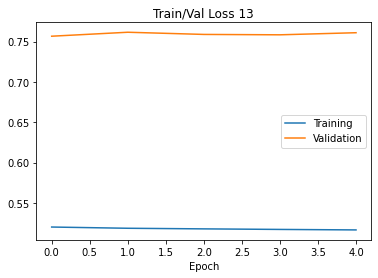

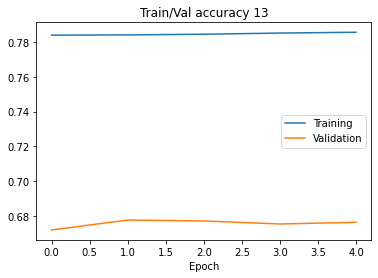

887/887 [==============================] - 5s 6ms/step - loss: 0.7499 - accuracy: 0.6800
(0.7498562335968018, 0.6799619197845459)
887/887 [==============================] - 5s 5ms/step - loss: 0.7499 - accuracy: 0.6800
Results:  adagrad   13   [0.7498562335968018, 0.6799619197845459]
Epoch 1/5
414/414 [==============================] - 8s 16ms/step - loss: 0.5169 - accuracy: 0.7868 - val_loss: 0.7607 - val_accuracy: 0.6772

Epoch 00001: val_accuracy improved from -inf to 0.67717, saving model to ./songs/experiment_13\checkpoint_13
Epoch 2/5
414/414 [==============================] - 6s 14ms/step - loss: 0.5126 - accuracy: 0.7896 - val_loss: 0.7602 - val_accuracy: 0.6772

Epoch 00002: val_accuracy did not improve from 0.67717
Epoch 3/5
414/414 [==============================] - 6s 14ms/step - loss: 0.5164 - accuracy: 0.7864 - val_loss: 0.7601 - val_accuracy: 0.6773

Epoch 00003: val_accuracy improved from 0.67717 to 0.67732, saving model to ./songs/experiment_13\checkpoint_13
Epoch 4/5


INFO:tensorflow:Assets written to: ./songs/experiment_14\assets


INFO:tensorflow:Assets written to: ./songs/experiment_14\assets


ExperimentId: 14


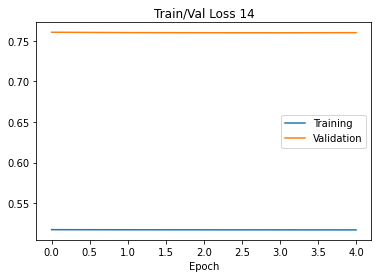

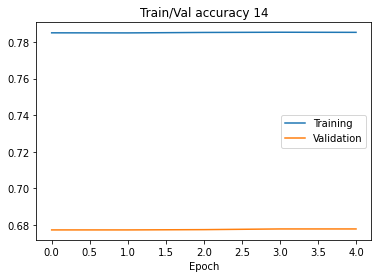

887/887 [==============================] - 5s 5ms/step - loss: 0.7488 - accuracy: 0.6795
(0.748822808265686, 0.6794682145118713)
887/887 [==============================] - 5s 5ms/step - loss: 0.7488 - accuracy: 0.6795
Results:  adadelta   14   [0.748822808265686, 0.6794682145118713]
Epoch 1/5
414/414 [==============================] - 12s 22ms/step - loss: 0.5734 - accuracy: 0.7568 - val_loss: 0.7445 - val_accuracy: 0.6773

Epoch 00001: val_accuracy improved from -inf to 0.67732, saving model to ./songs/experiment_14\checkpoint_14
Epoch 2/5
414/414 [==============================] - 9s 21ms/step - loss: 0.5491 - accuracy: 0.7667 - val_loss: 0.7564 - val_accuracy: 0.6623

Epoch 00002: val_accuracy did not improve from 0.67732
Epoch 3/5
414/414 [==============================] - 8s 20ms/step - loss: 0.5327 - accuracy: 0.7754 - val_loss: 0.7615 - val_accuracy: 0.6485

Epoch 00003: val_accuracy did not improve from 0.67732
Epoch 4/5
414/414 [==============================] - 8s 20ms/step -

INFO:tensorflow:Assets written to: ./songs/experiment_15\assets


INFO:tensorflow:Assets written to: ./songs/experiment_15\assets


ExperimentId: 15


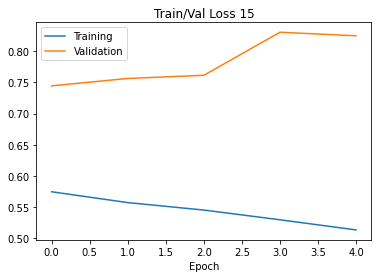

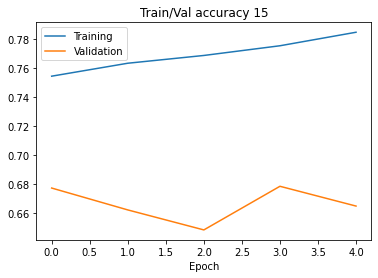

887/887 [==============================] - 5s 5ms/step - loss: 0.8192 - accuracy: 0.6676
(0.8192371129989624, 0.6675835847854614)
887/887 [==============================] - 5s 5ms/step - loss: 0.8192 - accuracy: 0.6676
Results:  rmsprop   15   [0.8192371129989624, 0.6675835847854614]


In [30]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    LSTM(32), 
    Dense(24, activation='relu'),
    Dense(3, activation='softmax')
])
for optimizer in ['adam', 'nadam', 'adamax', 'adagrad', 'adadelta', 'rmsprop']:
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    model, exp_id = experiment_controller.run_experiment(model, training_pd, training_lbls)

    print("ExperimentId:", exp_id)
    experiment_controller.plot_model_loss()
    experiment_controller.plot_model_loss("accuracy")
    print(experiment_controller.test(testing_pd, testing_lbls))
    res = model.evaluate(testing_pd, testing_lbls)
    print("Results: ", optimizer, " ", exp_id, " ", res)

**Adam parece ser el optimizador que mejor minimiza las funcion de costo para este problema**

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_27 (Embedding)     (None, 128, 32)           320000    
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 64)                16640     
_________________________________________________________________
dense_47 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 3)                 387       
Total params: 345,347
Trainable params: 345,347
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
414/414 [==============================] - 13s 24ms/step - loss: 0.9108 - accuracy: 0.5690 - val_loss: 0.7661 - val_accuracy: 0.6469

Epoch 00001: val_accuracy improved from -inf to 0.64687, saving model to ./songs/experiment_27\checkpoint_27
Epoch 2/5
414/414 [==============================] - 9s 22ms/step - loss: 0.7054 - accuracy: 0.6846 - val_loss: 0.7209 - val_accuracy: 0.6751

Epoch 00002: val_accuracy improved from 0.64687 to 0.67513, saving model to ./songs/experiment_27\checkpoint_27
Epoch 3/5
414/414 [==============================] - 9s 21ms/step - loss: 0.6593 - accuracy: 0.7084 - val_loss: 0.7103 - val_accuracy: 0.6835

Epoch 00003: val_accuracy improved from 0.67513 to 0.68352, saving model to ./songs/experiment_27\checkpoint_27
Epoch 4/5
414/414 [==============================] - 9s 21ms/step - loss: 0.6268 - accuracy: 0.7273 - val_loss: 0.7445 - val_accuracy: 0.6704

Epoch 00004: val_accuracy did not improve from 0.68352
Epoch 5/5
414/414 [====================

INFO:tensorflow:Assets written to: ./songs/experiment_28\assets


INFO:tensorflow:Assets written to: ./songs/experiment_28\assets


ExperimentId: 28


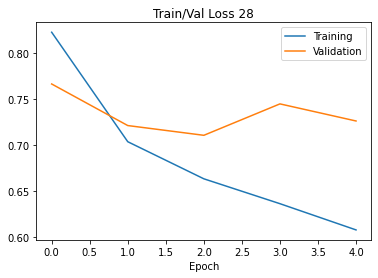

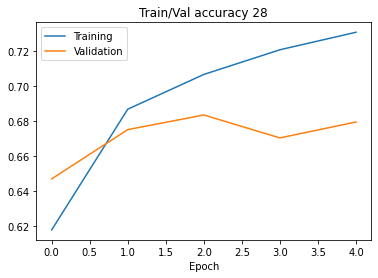

887/887 [==============================] - 7s 8ms/step - loss: 0.7206 - accuracy: 0.6802
(0.7205769419670105, 0.6801735162734985)


In [77]:
model = Sequential([
    Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_initializer="glorot_normal", dropout=0.5, activation="tanh", recurrent_regularizer=L1L2(l1=0.01, l2=0.01))), 
    Dense(128, activation='relu', kernel_initializer=GlorotNormal()),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
model, exp_id = experiment_controller.run_experiment(model, training_pd, training_lbls)

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(testing_pd, testing_lbls))

In [ ]:
x = Input(shape=(MAX_LENGTH,))
z = Input(shape=(1,))

x = Embedding(VOCAB_SIZE, EMBEDDING_DIM)(x)
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, kernel_initializer="glorot_normal", dropout=0.5, activation="tanh", recurrent_regularizer=L1L2(l1=0.01, l2=0.01)))(x)
y = Concatenate(axis = 1)([x, z])
x = Dense(128, activation='relu', kernel_initializer=GlorotNormal())(y)
x = Dropout(0.5)(y)
output = Dense(3, activation='softmax')(y)

model = Model(inputs = x, outputs = output)

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()
model, exp_id = experiment_controller.run_experiment(model, training_pd, training_lbls)

print("ExperimentId:", exp_id)
experiment_controller.plot_model_loss()
experiment_controller.plot_model_loss("accuracy")
print(experiment_controller.test(testing_pd, testing_lbls))

In [73]:
experiment_controller.summary_experiments().sort_values(f"val_accuracy", ascending=False)

,ExperimentID,Datetime,train_accuracy,val_accuracy
1,2,20210924-03:15:59,0.724650,0.681100
24,25,20210924-15:49:14,0.719209,0.679891
21,22,20210924-15:34:30,0.764911,0.679362
13,14,20210924-14:38:54,0.785316,0.677700
12,13,20210924-14:38:08,0.785505,0.676415
23,24,20210924-15:41:34,0.699579,0.674299
0,1,20210924-03:07:48,0.737157,0.673846
8,9,20210924-14:26:18,0.779251,0.669160
19,20,20210924-15:27:59,0.781764,0.668783
22,23,20210924-15:36:15,0.755144,0.668178


In [90]:
experiment_controller.compare_test_results().sort_values(f"test_loss", ascending=False)

,ExperimentID,Datetime,test_loss,test_accuracy
16,20210924-15:11:41,0.690468,0.691882,NaN
21,20210924-15:32:50,0.690823,0.688990,NaN
18,20210924-15:23:37,0.701885,0.688461,NaN
17,20210924-15:18:24,0.699857,0.688285,NaN
8,20210924-14:13:56,0.691638,0.688038,NaN
25,20210924-15:49:21,0.715231,0.686627,NaN
20,20210924-15:28:06,0.702644,0.684970,NaN
2,20210924-03:16:49,0.724557,0.684159,NaN
10,20210924-14:35:49,0.721120,0.683665,NaN
11,20210924-14:36:52,0.722323,0.680385,NaN


In [ ]:
%load_ext tensorboard
%tensorboard --logdir=songs/logs/tensorboard